In [1]:
import pandas as pd
import os

current_path = os.getcwd()
print(f"Initial CWD: {current_path}")

if os.path.basename(current_path).lower() == "src":
    print(f"Current directory is already named 'src': {current_path}")
elif os.path.isdir(os.path.join(current_path, "src")):
    print(f"Changing CWD to 'src' subdirectory: {os.path.join(current_path, 'src')}")
    os.chdir(os.path.join(current_path, "src"))
else:
    raise FileNotFoundError(
        f"Could not find 'src' directory. CWD: {current_path}. "
        "Ensure 'src' is a subdirectory or your notebook is in 'src'."
    )
print(f"Final CWD: {os.getcwd()}")

from backtesting.sentiment_analyzer_mt5.sentiment_analyzer_mt5 import BacktestSentimentAnalyzer
from backtesting.platform_conector_mt5.platform_connector_mt5 import BacktestPlatformConnector
from backtesting.data_source_mt5.data_source_mt5 import MT5BacktestDataSource
from portfolio.portfolio import Portfolio
from backtesting_director.backtesting_director import BacktestingDirector
from strategy_manager.strategy_manager import StrategyManager
from strategy_manager.properties.strategy_manager_properties import MACrossoverProps, RSIProps
from position_sizer.position_sizer import PositionSizer
from position_sizer.properties.position_sizer_properties import FixedSizingProps
from risk_manager.risk_manager import RiskManager
from risk_manager.properties.risk_manager_properties import MaxLeverageFactorRiskProps
from backtesting.data_display_mt5.data_display_mt5 import DataDisplayMT5
from backtesting.order_executor_mt5.order_executor_mt5 import BacktestOrderExecutor
from queue import Queue

Initial CWD: c:\Mac\Home\Documents\PythonTradingBot
Changing CWD to 'src' subdirectory: c:\Mac\Home\Documents\PythonTradingBot\src
Final CWD: c:\Mac\Home\Documents\PythonTradingBot\src


c:\Users\ronaldjaviervezgarue\anaconda3\envs\TradingFramework\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
symbols = ["EURUSD"]
timeframe = "H1"
magic_number = 12345
volume = 0.10
max_leverage_factor = 5
start_date = "2023-01-01"
end_date = "2023-05-01"
csv_sentiment_file_path = r"c:\Mac\Home\Documents\PythonTradingBot\src\backtesting\dataset\sentiment_annotated_with_texts.csv"
#csv_sentiment_file_path = "./src/backtesting/dataset/sentiment_annotated_with_texts.csv"
USE_BACKTEST_SENTIMENT_ANALYZER = True

mac_props = MACrossoverProps(
    timeframe=timeframe,
    slow_period=10,
    fast_period=5,
)

rsi_props = RSIProps(
    timeframe=timeframe,
    rsi_period=14,
    rsi_upper=70.0,
    rsi_lower=30.0,
    sl_points=200,
    tp_points=400,
)

events_queue = Queue()

BACKTEST_CONNECT = BacktestPlatformConnector()
initial_balance = BACKTEST_CONNECT.get_balance()

BACKTEST_DATA_SOURCE = MT5BacktestDataSource(events_queue=events_queue, symbols=symbols, timeframe=timeframe,
                                    start_date=start_date, end_date=end_date)

PORTFOLIO = Portfolio(magic_number=magic_number, platform_connector=BACKTEST_CONNECT)

BACKTEST_ORDER_EXECUTOR = BacktestOrderExecutor(
    platform_connector=BACKTEST_CONNECT,
    events_queue=events_queue,
    data_source=BACKTEST_DATA_SOURCE,
    portfolio=PORTFOLIO
)

BACKTEST_SENTIMENT_ANALYZER = None
if USE_BACKTEST_SENTIMENT_ANALYZER:
    if csv_sentiment_file_path and os.path.exists(csv_sentiment_file_path):
        print(f"Bactest Sentiment Analysis enabled with this csv file: {csv_sentiment_file_path}")
        BACKTEST_SENTIMENT_ANALYZER = BacktestSentimentAnalyzer(csv_file_path=csv_sentiment_file_path)
    else:
        print("WARN: Bactest Sentiment Analysis enabled but csv file not found news fetching will fail.")
        BACKTEST_SENTIMENT_ANALYZER = BacktestSentimentAnalyzer(csv_file_path=csv_sentiment_file_path)
else:
    print("Bactest Sentiment Analysis is disabled by configuration.")

STRATEGY_MANAGER = StrategyManager(
    events_queue=events_queue,
    data_source=BACKTEST_DATA_SOURCE,
    portfolio=PORTFOLIO,
    order_executor=BACKTEST_ORDER_EXECUTOR,
    strategy_properties=mac_props,
    sentiment_analyzer=BACKTEST_SENTIMENT_ANALYZER
)

POSITION_SIZER = PositionSizer(
    events_queue=events_queue,
    data_source=BACKTEST_DATA_SOURCE,
    sizing_properties=FixedSizingProps(volume=volume)
)

RISK_MANAGER = RiskManager(
    events_queue=events_queue,
    data_source=BACKTEST_DATA_SOURCE,
    portfolio=PORTFOLIO,
    risk_properties=MaxLeverageFactorRiskProps(max_leverage_factor=max_leverage_factor)
)

BACKTESTING_DIRECTOR = BacktestingDirector(
    events_queue=events_queue,
    data_source=BACKTEST_DATA_SOURCE,
    strategy_manager=STRATEGY_MANAGER,
    position_sizer=POSITION_SIZER,
    risk_manager=RISK_MANAGER,
    order_executor=BACKTEST_ORDER_EXECUTOR,
)

BACKTESTING_DIRECTOR.run()

print("\n--- Backtest Finished ---")
print(f"Initial Balance: {initial_balance:.2f}")
final_balance = BACKTEST_CONNECT.get_balance()
print(f"Final Balance: {final_balance:.2f}")
print(f"Final Equity: {BACKTEST_CONNECT.get_equity():.2f}")

trade_log_df = pd.DataFrame(BACKTEST_ORDER_EXECUTOR.get_trade_log())

Bactest Sentiment Analysis enabled with this csv file: c:\Mac\Home\Documents\PythonTradingBot\src\backtesting\dataset\sentiment_annotated_with_texts.csv


c:\Users\ronaldjaviervezgarue\anaconda3\envs\TradingFramework\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


INFO: Loading news data from CSV: c:\Mac\Home\Documents\PythonTradingBot\src\backtesting\dataset\sentiment_annotated_with_texts.csv
INFO: Successfully loaded and preprocessed 2291 news items from CSV.
2025-06-15 15:51:06 - Receiving DATA EVENT from: EURUSD - last close price: 1.06898
MA Crossover: Performing sentiment analysis for EURUSD.
INFO: Analyzing sentiment for ticker 'EURUSD' on date '2023-01-02 00:00:00' with lookback of 7 days and analyzing 50 articles.
INFO: Filtered and cached 758 news items for ticker 'EURUSD'.
MA Crossover: Evaluating sentiment for EURUSD for . Sufficient news: False, Avg Score: 0.00, Analyzed: 0
MA Crossover: Not enough news analyzed (0) for EURUSD to modify strategy based on sentiment, or analysis did not yield sufficient data.
2025-06-15 15:51:06 - Receiving DATA EVENT from: EURUSD - last close price: 1.07056
MA Crossover: Sentiment analysis for EURUSD skipped, last check was on 2023-01-02 00:00:00.
2025-06-15 15:51:06 - Receiving DATA EVENT from: EURU

In [3]:
if not trade_log_df.empty:
    print("\n--- Trade Log ---")
    print(trade_log_df.head())

else:
    print("No trades were executed.")


--- Trade Log ---
                                 ticket  symbol open_side  entry_price  \
0  6c6374a7-19dc-4b85-acba-f347437b2539  EURUSD       buy      1.06958   
1  27b5316b-8c45-4022-ba5a-d6b57d9f7a9f  EURUSD      sell      1.06972   
2  ab3d2821-2489-44e1-92ed-ec4a7f65fc55  EURUSD       buy      1.06770   
3  1d336ec1-d600-419a-8d9a-779c8a35472a  EURUSD      sell      1.06240   
4  deeea00a-90b1-48b8-b465-7c37c6d746c9  EURUSD       buy      1.05581   

           entry_time  volume close_side  exit_price           exit_time  \
0 2023-01-02 05:00:00     0.1       sell     1.06972 2023-01-02 07:00:00   
1 2023-01-02 07:00:00     0.1        buy     1.06770 2023-01-03 01:00:00   
2 2023-01-03 01:00:00     0.1       sell     1.06240 2023-01-03 09:00:00   
3 2023-01-03 09:00:00     0.1        buy     1.05581 2023-01-03 18:00:00   
4 2023-01-03 18:00:00     0.1       sell     1.05488 2023-01-03 23:00:00   

   profit  magic   sl   tp  
0     1.4  12345  0.0  0.0  
1    20.2  12345  0.0

In [4]:
if not trade_log_df.empty:
    display = DataDisplayMT5(trade_log_df=trade_log_df, initial_balance=initial_balance)
    display.display_summary()

else:
    print("No trades were executed.")


--- Backtest Summary ---
Total Intentos Registrados: 228
Operaciones Canceladas por Sentiment Analyzer: N/A (columna 'cancellation_reason' no disponible)
Total Operaciones Ejecutadas: 228
Total Profit/Loss: 299.00
Gross Profit: 2727.40
Gross Loss: -2428.40
Winning Trades: 90
Losing/Neutral Trades: 138
Win Rate (%): 39.47
Average Win ($): 30.30
Average Loss ($): -17.73
Profit Factor: 1.12
Max Drawdown ($): -741.40
Max Drawdown (%): 0.74
Sharpe Ratio (simplificado): 0.62
---------------------------



Cannot plot trade count: missing 'Winning Trades' or 'Losing Trades' metrics.


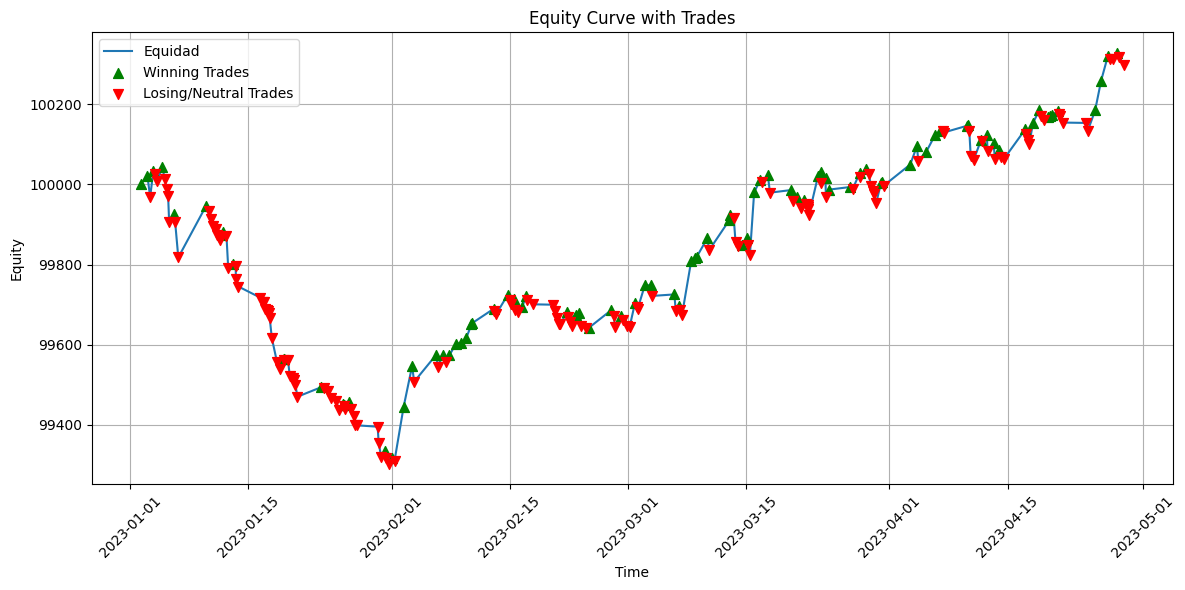

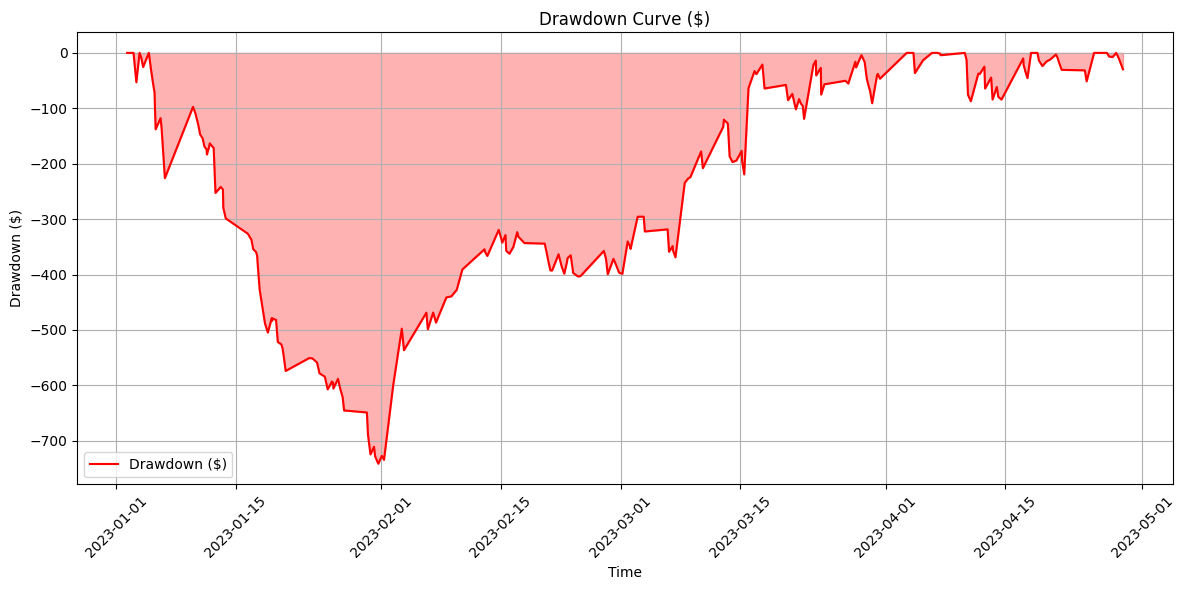

In [5]:
if not trade_log_df.empty:
    display.plot_win_loss_trades_bar_chart()
    display.plot_equity_curve_and_trades()
    display.plot_drawdown_curve()

else:
    print("No trades were executed.")